# Create rolling G/A1/A2 graphs for individuals
Game plan: read game by game stats, set parameters, calculate, plot. 5v5 only.

### Import

In [1]:
import PbPMethods2 as pm2
from pylab import *
%matplotlib inline
import pandas as pd
import GetPbP

### Generate game-by-game data 
Do this only if you haven't already at least once. (It saves to file, so you don't need to run it every time you open this notebook.) Re-run to update current season data. (The '#' ensures code after it on the same line doesn't run.)
<p>This will take a long time and give you some errors--known errors are <a href="https://github.com/muneebalam/Hockey/blob/master/NHL/Quick-graphs/gengamebygameerrors.txt">listed here</a>.

In [2]:
seasons_to_update = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
#pm2.gen_gamebygame(season)

### Read in game by game data
Do this only once, each time you open this notebook, to load data into memory.

In [3]:
dfs = []
for season in range(2007, 2016):
    dfs.append(pd.read_csv(pm2.get_gamebygame_data_filename(season)))
dfs = pd.concat(dfs)
dfs.head()

,Player,Team,Pos,Game,Season,Date,TOION(60s),CFON,CAON,TOIOFF(60s),...,NZS,OZS,iG,iCF,iA1,iA2,SACFON,SACAON,SACFOFF,SACAOFF
0,Patrick O'Sullivan,L.A,F,20001,2007,29-Sep-07,0.110556,3,4,0.457500,...,2,2,0,1,0,0,3.324,3.554,8.560,22.067
1,Tom Preissing,L.A,D,20001,2007,29-Sep-07,0.154444,5,7,0.413611,...,4,2,0,1,0,0,5.430,6.509,6.454,19.112
2,Lubomir Visnovsky,L.A,D,20001,2007,29-Sep-07,0.185833,2,9,0.382222,...,5,3,0,0,0,0,2.077,8.354,9.807,17.267
3,Raitis Ivanans,L.A,F,20001,2007,29-Sep-07,0.059722,1,2,0.508333,...,2,0,0,0,0,0,1.120,1.826,10.764,23.795
4,Dustin Brown,L.A,F,20001,2007,29-Sep-07,0.163889,4,9,0.404167,...,3,2,0,1,0,0,4.228,8.040,7.656,17.581


### Select the player, teams, seasons etc you want.
If you want to generate more graphs start re-running code from here.

In [4]:
player = 'Sidney Crosby'
start_date = '2007-09-15' #use mid-Sept to be safe because some seasons have Euro premiere games
end_date = '2016-06-21' #Format: yyyy-mm-dd

teams = 'all' #or, e.g. {'WSH'}, or {'WSH', 'T.B'}
roll_len = 82 #in games

include_playoffs = True #can also set to False
save_file = None #set to something to save figure
gapless = True #Will avoid long offseason flatlines (no games = no change in CF%)
ratestats = True #will divide by TOI if True
    
if teams == 'all':
    teams = GetPbP.TEAMS

### Filter based on above parameters
Note how I select a date range here. This can be very useful (for example, if you want to edit the usage charts notebook code to take a date range instead of specific seasons).

In [5]:
df = dfs[dfs.Player == player]
df = df[df.Team.apply(lambda x: x in teams)]

df['Date2'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.sort_values('Date2', inplace=True)
df.set_index('Date2', inplace=True)
df = df.ix[start_date : end_date]

if gapless:
    df.reset_index(inplace=True)

if not include_playoffs:
    df = df[df.Game <= 21230]

### Calculate

In [6]:
cols_to_use = ['iG', 'iA1', 'iA2', 'GFON']
base = '{0:d}-game '.format(roll_len)

df[base + 'TOI'] = pd.rolling_sum(df['TOION(60s)'], roll_len, 0)
if ratestats:
    divisor = df[base + 'TOI']
else:
    divisor = 1    

df[base + 'G'] = pd.rolling_sum(df['iG'], roll_len, 0)/divisor
df[base + 'A1'] = pd.rolling_sum(df['iA1'], roll_len, 0)/divisor
df[base + 'A2'] = pd.rolling_sum(df['iA2'], roll_len, 0)/divisor
df[base + 'GFON'] = pd.rolling_sum(df['GFON'], roll_len, 0)/divisor

In [7]:
def format_timestamp_as_mdyy(ts):
    st = str(ts).split(' ')[0]
    y, m, d = st.split('-')
    m = int(m)
    d = int(d)
    return '{0:d}/{1:d}\n{2:s}'.format(m, d, y)

In [8]:
next_year_indices = [0]
start_date2 = pd.Timestamp(start_date)
next_year_dates = [format_timestamp_as_mdyy(start_date2)]
years_elapsed = 0
oneyr = pd.Timedelta('365 days')
for i in range(1, len(df)):
    if gapless:
        current_date = df['Date2'].iloc[i]
    else:
        current_date = df.index[i]
    if current_date - start_date2 >= (years_elapsed + 1) * oneyr:
        next_year_indices.append(i)
        next_year_dates.append(format_timestamp_as_mdyy(current_date))
        years_elapsed += 1

### Plot

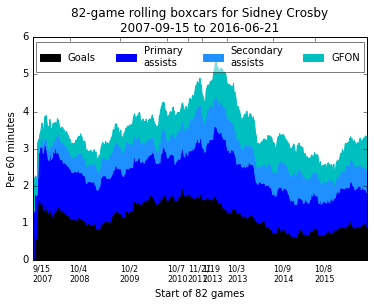

In [9]:
fill_between(df.index, 0, df[base + 'G'], label='Goals', color='k')
fill_between(df.index, df[base + 'G'], df[base + 'G'] + df[base + 'A1'], 
             label='Primary\nassists', color='b')
fill_between(df.index, df[base + 'G'] + df[base + 'A1'], 
             df[base + 'G'] + df[base + 'A1'] + df[base + 'A2'], 
             label='Secondary\nassists', color='dodgerblue')
fill_between(df.index, df[base + 'G'] + df[base + 'A1'] + df[base + 'A2'], 
             df[base + 'GFON'], 
             label='GFON', color='c')

if gapless:
    xlim(0, len(df))
    xticks(next_year_indices, next_year_dates, ha='left', fontsize=8)
else:
    xlim(start_date, end_date)
titletext = '{0:d}-game rolling boxcars for {1:s}'.format(roll_len, player)
titletext += '\n{0:s} to {1:s}'.format(start_date, end_date)
title(titletext)
xlabel('Start of {0:d} games'.format(roll_len))
if ratestats:
    ylabel('Per 60 minutes')

legend(loc=9, framealpha=0.5, ncol=4, fontsize=10)

if save_file is not None:
    savefig(save_file)